In [105]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV #ordinary linear regression + w/ ridge regularization
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('clean_imdb_2.csv')

In [3]:
df.head()

,title,year,rating,num_reviews,genre,certificate,num_episodes,actors,network,runtime,awards
0,Level Up,2012.0,4.3,897,Sci-Fi,TV-PG,36,Gaelan Connell,Cartoon Network,30.0,0.0
1,Behind the Scenes,2012.0,8.0,12,Comedy,Not Rated,68,Keith Stoller,Lost Angeles Films,90.0,0.0
2,Mama Drama,2012.0,5.9,28,Reality-TV,Not Rated,10,Missing,495 Productions,60.0,0.0
3,Oprah Prime,2012.0,4.5,212,Talk-Show,Not Rated,86,Oprah Winfrey,Harpo Productions,60.0,1.0
4,Gator Boys,2012.0,7.0,609,Reality-TV,Not Rated,36,Paul Bedard,Mike Mathis Productions,60.0,0.0


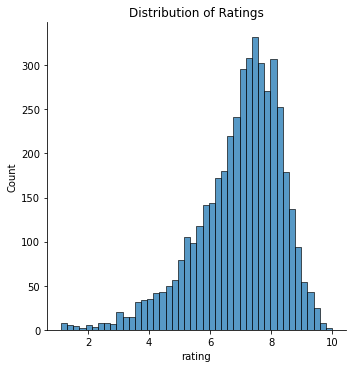

In [4]:
# check distribution of target variable
sns.displot(df.rating)
plt.title('Distribution of Ratings')
plt.savefig('ratings_dis.png', bbox_inches='tight')

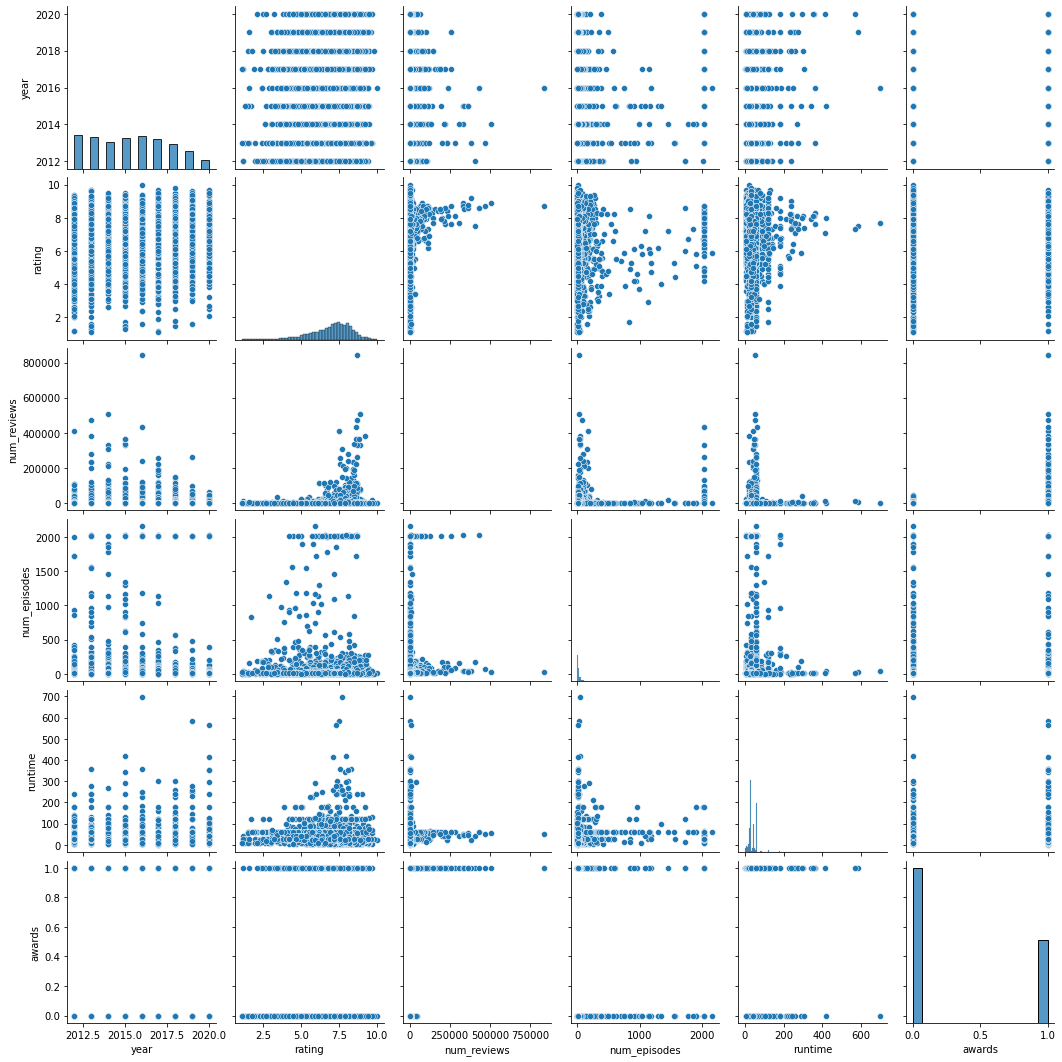

In [5]:
# check relationships between numeric features and target 

sns.pairplot(df)

In [6]:
# check correlations

df.corr()

,year,rating,num_reviews,num_episodes,runtime,awards
year,1.000000,0.022515,0.000526,0.043981,0.047228,0.075033
rating,0.022515,1.000000,0.131525,-0.011724,-0.004936,0.110483
num_reviews,0.000526,0.131525,1.000000,0.133838,0.039140,0.243369
num_episodes,0.043981,-0.011724,0.133838,1.000000,0.043015,0.123368
runtime,0.047228,-0.004936,0.039140,0.043015,1.000000,0.034635
awards,0.075033,0.110483,0.243369,0.123368,0.034635,1.000000


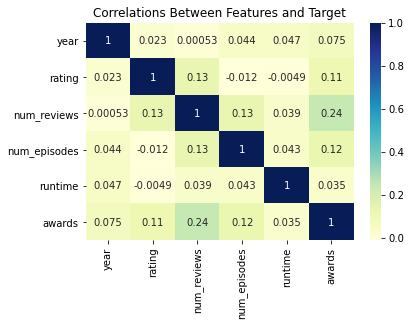

In [7]:
# plot heatmap
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.title('Correlations Between Features and Target')
plt.savefig('ratings_corr', bbox_inches='tight')

In [8]:
#baseline model & OLS regression summary stats
X = df.loc[:,['year', 'awards', 'num_episodes', 
                      'runtime', 'num_reviews']]

y = df['rating']

model = sm.OLS(y,sm.add_constant(X))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     23.69
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           1.37e-23
Time:                        19:09:24   Log-Likelihood:                -7747.4
No. Observations:                4499   AIC:                         1.551e+04
Df Residuals:                    4493   BIC:                         1.555e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -14.5869     17.400     -0.838      0.402     -48.699      19.526
year             0.0106      0.009      1.233      0.218      -0.006       0.028
awards           0.2473      0.044      5.620      0.000       0.161       0.334
num_episodes    -0.0002   7.89e-05     -2.554      0.011      -0.000   -4.69e-05
runtime         -0.0005      0.001     -0.791      0.429      -0.002       0.001
num_reviews   5.463e-06   7.19e-07      7.601      0.000    4.05e-06    6.87e-06
==============================================================================
Omnibus:                      576.000   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              887.653
Skew:                          -0.912   Prob(JB):                    1.77e-193
Kurtosis:                       4.187   Cond. No.                     2.56e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
results.save('baseline_ols_model.pkl')

Add dummy variables

In [11]:
# grouping actors into top 20 first
df.actors.value_counts()


Missing                  353
Aaron Elliott              8
Steve Harvey               6
Gordon Ramsay              6
Kal Penn                   6
                        ... 
Christina Ricci            1
Shelly Desai               1
Brandon Scott              1
Vanessa Bell Calloway      1
Sophie Pollono             1
Name: actors, Length: 3682, dtype: int64

In [12]:
# choose only top 20 actors
topactors = list(df.actors.value_counts().head(20).keys())
def big_actors(string):
    if string in (topactors):
        return string
    else:
        return 'other'
df['top_actors'] = df.actors.apply(big_actors)

In [13]:
df.head()

,title,year,rating,num_reviews,genre,certificate,num_episodes,actors,network,runtime,awards,top_actors
0,Level Up,2012.0,4.3,897,Sci-Fi,TV-PG,36,Gaelan Connell,Cartoon Network,30.0,0.0,other
1,Behind the Scenes,2012.0,8.0,12,Comedy,Not Rated,68,Keith Stoller,Lost Angeles Films,90.0,0.0,other
2,Mama Drama,2012.0,5.9,28,Reality-TV,Not Rated,10,Missing,495 Productions,60.0,0.0,Missing
3,Oprah Prime,2012.0,4.5,212,Talk-Show,Not Rated,86,Oprah Winfrey,Harpo Productions,60.0,1.0,Oprah Winfrey
4,Gator Boys,2012.0,7.0,609,Reality-TV,Not Rated,36,Paul Bedard,Mike Mathis Productions,60.0,0.0,other


In [14]:
# group networks

df.network.value_counts()

Missing                            654
Amazon Studios                      48
ABC Signature                       23
DreamWorks Animation Television     22
3 Arts Entertainment                22
                                  ... 
Reel Films Cinema Entertainment      1
Beware Doll Films                    1
Katalyst Films                       1
New Zealand Son Films                1
Game Show Network (GSN)              1
Name: network, Length: 2281, dtype: int64

In [15]:
# choose only top 20 networks
top_networks = list(df.network.value_counts().head(20).keys())
def big_network(string):
    if string in (top_networks):
        return string
    else:
        return 'other'
df['top_networks'] = df.network.apply(big_network)

In [16]:
df.top_networks.value_counts()

other                              3510
Missing                             654
Amazon Studios                       48
ABC Signature                        23
DreamWorks Animation Television      22
3 Arts Entertainment                 22
Netflix                              21
Berlanti Productions                 20
Disney Television Animation          19
Blind Wave                           16
Bunim-Murray Productions (BMP)       16
Entertainment One                    15
Cartoon Network Studios              15
Sharp Entertainment                  14
Vice Media                           13
Bellum Entertainment                 12
Leftfield Pictures                   12
Embassy Row                          12
CBS Television Studios               12
Pilgrim Studios                      12
495 Productions                      11
Name: top_networks, dtype: int64

In [17]:
df.set_index('title', inplace=True)
df.head()

,year,rating,num_reviews,genre,certificate,num_episodes,actors,network,runtime,awards,top_actors,top_networks
title,,,,,,,,,,,,
Level Up,2012.0,4.3,897,Sci-Fi,TV-PG,36,Gaelan Connell,Cartoon Network,30.0,0.0,other,other
Behind the Scenes,2012.0,8.0,12,Comedy,Not Rated,68,Keith Stoller,Lost Angeles Films,90.0,0.0,other,other
Mama Drama,2012.0,5.9,28,Reality-TV,Not Rated,10,Missing,495 Productions,60.0,0.0,Missing,495 Productions
Oprah Prime,2012.0,4.5,212,Talk-Show,Not Rated,86,Oprah Winfrey,Harpo Productions,60.0,1.0,Oprah Winfrey,other
Gator Boys,2012.0,7.0,609,Reality-TV,Not Rated,36,Paul Bedard,Mike Mathis Productions,60.0,0.0,other,other


In [18]:
# pickle the dataframe that includes top_actors and top_networks columns
df.to_pickle('grouped_act_net.pkl')

In [19]:
df.drop(columns=['actors', 'network'], inplace=True)

In [20]:
df.head()

,year,rating,num_reviews,genre,certificate,num_episodes,runtime,awards,top_actors,top_networks
title,,,,,,,,,,
Level Up,2012.0,4.3,897,Sci-Fi,TV-PG,36,30.0,0.0,other,other
Behind the Scenes,2012.0,8.0,12,Comedy,Not Rated,68,90.0,0.0,other,other
Mama Drama,2012.0,5.9,28,Reality-TV,Not Rated,10,60.0,0.0,Missing,495 Productions
Oprah Prime,2012.0,4.5,212,Talk-Show,Not Rated,86,60.0,1.0,Oprah Winfrey,other
Gator Boys,2012.0,7.0,609,Reality-TV,Not Rated,36,60.0,0.0,other,other


In [21]:
new_df = pd.get_dummies(df, columns=['genre', 'certificate', 'top_actors', 'top_networks'], drop_first=True)

In [22]:
new_df.head()

,year,rating,num_reviews,num_episodes,runtime,awards,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,...,top_networks_DreamWorks Animation Television,top_networks_Embassy Row,top_networks_Entertainment One,top_networks_Leftfield Pictures,top_networks_Missing,top_networks_Netflix,top_networks_Pilgrim Studios,top_networks_Sharp Entertainment,top_networks_Vice Media,top_networks_other
title,,,,,,,,,,,,,,,,,,,,,
Level Up,2012.0,4.3,897,36,30.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Behind the Scenes,2012.0,8.0,12,68,90.0,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Mama Drama,2012.0,5.9,28,10,60.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Oprah Prime,2012.0,4.5,212,86,60.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Gator Boys,2012.0,7.0,609,36,60.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Dummy variables created for genre, top_networks, top_actors, and certificate columns

In [23]:
# Split data into train and test sets

X, y = new_df.drop('rating',axis=1), new_df['rating']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

X is the training dataset with features, y is the training dataset with the target variable

In [24]:
# Running cross validation on dataframe with simple linear regression and ridge

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s_val, cv_lm_reg_r2s_val = [], [] #collect the validation results for both models
cv_lm_r2s_train, cv_lm_reg_r2s_train = [], [] # collect the training results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind] # X_train, y_train
    X_val, y_val = X[val_ind], y[val_ind]  # X validation set, y validation set
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s_train.append(lm.score(X_train, y_train))
    cv_lm_r2s_val.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s_train.append(lm_reg.score(X_train_scaled, y_train))
    cv_lm_reg_r2s_val.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression training scores: ', cv_lm_r2s_train)
print('Simple regression validation scores: ', cv_lm_r2s_val, '\n')

print('Ridge training scores: ', cv_lm_reg_r2s_train)
print('Ridge validation scores: ', cv_lm_reg_r2s_val, '\n')

print(f'Simple mean cv train r^2: {np.mean(cv_lm_r2s_train):.3f} +- {np.std(cv_lm_r2s_train):.3f}')
print(f'Simple mean cv validation r^2: {np.mean(cv_lm_r2s_val):.3f} +- {np.std(cv_lm_r2s_val):.3f}', '\n')

print(f'Ridge mean train cv r^2: {np.mean(cv_lm_reg_r2s_train):.3f} +- {np.std(cv_lm_reg_r2s_train):.3f}')
print(f'Ridge mean validation cv r^2: {np.mean(cv_lm_reg_r2s_val):.3f} +- {np.std(cv_lm_reg_r2s_val):.3f}')

Simple regression training scores:  [0.10917511250835188, 0.12007065271444728, 0.12598519887815995, 0.11617682788309935, 0.1122027621917554]
Simple regression validation scores:  [0.10172993190688395, 0.010096388848325755, 0.03720613385908422, 0.05388957888097179, 0.07668236152868568] 

Ridge training scores:  [0.10917496548855021, 0.12006882570922495, 0.12598321684560787, 0.11617441849624688, 0.11220209116712998]
Ridge validation scores:  [0.10179150902804313, 0.01043545592093742, 0.03735321184127116, 0.054084920181000085, 0.07677704998589452] 

Simple mean cv train r^2: 0.117 +- 0.006
Simple mean cv validation r^2: 0.056 +- 0.032 

Ridge mean train cv r^2: 0.117 +- 0.006
Ridge mean validation cv r^2: 0.056 +- 0.031


Both models are overfitting on validation. Will try lasso. 

In [25]:
# need new variables for lasso
X2, y2 = new_df.drop('rating',axis=1), new_df['rating']

X2_train_val, X2_test, y2_train_val, y2_test = train_test_split(X2, y2, test_size=0.2,random_state=42)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train_val, y2_train_val, test_size=.25, random_state=43)

In [26]:
## Scale the data 
std = StandardScaler()
std.fit(X2_train.values)

StandardScaler()

In [27]:
len(X2_train)

2699

In [28]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X2_train.values)
X_te = std.transform(X2_test.values)
X_validation = std.transform(X2_val)

In [29]:
len(X_validation)

900

In [30]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y2_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [31]:
lasso_model.alpha_

0.018251834943190434

In [32]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X2_train.columns, lasso_model.coef_))

[('year', 0.0),
 ('num_reviews', 0.1298347675749638),
 ('num_episodes', -0.0020441610538402236),
 ('runtime', -0.0),
 ('awards', 0.08282171886936475),
 ('genre_Adventure', 0.005484174496740623),
 ('genre_Animation', -0.05913349758801907),
 ('genre_Biography', 0.03016436954503868),
 ('genre_Comedy', 0.0),
 ('genre_Crime', 0.0469699399088885),
 ('genre_Documentary', 0.017202342724560823),
 ('genre_Drama', 0.024410983022652863),
 ('genre_Family', -0.0),
 ('genre_Fantasy', -0.0),
 ('genre_Game-Show', -0.12141603445354783),
 ('genre_History', 0.01630440541194537),
 ('genre_Horror', -0.0),
 ('genre_Missing', 0.01372936815659797),
 ('genre_Music', 0.002816663196825972),
 ('genre_Musical', -0.020345966803606137),
 ('genre_Mystery', 0.0),
 ('genre_News', -0.09442179142643062),
 ('genre_Reality-TV', -0.15443070361391137),
 ('genre_Romance', 0.0),
 ('genre_Sci-Fi', -0.042646014797409364),
 ('genre_Short', 0.04358129932940563),
 ('genre_Sport', 0.04392236252722818),
 ('genre_Talk-Show', -0.0453678

In [33]:
# predictions on training set
train_set_pred = lasso_model.predict(X_tr)

In [34]:
r2_score(y2_train, train_set_pred)

0.10952372350011386

In [35]:
#predictions on validation set
validation_pred = lasso_model.predict(X_validation)

In [36]:
r2_score(y2_val, validation_pred)

0.06120798605180344

In [37]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [38]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [39]:
# Find the MAE and R^2 on the test set using this model
mae(y2_test, test_set_pred)

1.0214256851948686

In [40]:
r2_score(y2_test, test_set_pred)

0.12956965557364897

Model is overfitting - going to try larger range of alphas

In [69]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-10,10, 200)

lasso_model2 = LassoCV(alphas = alphavec, cv=5, max_iter=2000)
lasso_model2.fit(X_tr, y2_train)

LassoCV(alphas=array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5.11143348e-09, 6.44236351e-09, 8.11984499e-09,
       1.02341140e-08, 1.28989026e-0...
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]),
        cv=5, max_iter=2000)

In [70]:
lasso_model2.alpha_

0.017426333860096545

In [71]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X2_train.columns, lasso_model.coef_))

[('year', 0.0),
 ('num_reviews', 0.13989690532420723),
 ('num_episodes', -0.010230864121639045),
 ('runtime', -0.0),
 ('awards', 0.09514579648571832),
 ('genre_Adventure', 0.012808621167028416),
 ('genre_Animation', -0.06594408480786686),
 ('genre_Biography', 0.03804143386582172),
 ('genre_Comedy', 0.0),
 ('genre_Crime', 0.05543334669006354),
 ('genre_Documentary', 0.022613807179437742),
 ('genre_Drama', 0.031891155930497114),
 ('genre_Family', -0.007765854736044988),
 ('genre_Fantasy', -0.0),
 ('genre_Game-Show', -0.13111193083774886),
 ('genre_History', 0.02515039552853975),
 ('genre_Horror', -0.001695876444390824),
 ('genre_Missing', 0.01959771842272813),
 ('genre_Music', 0.012645431575263821),
 ('genre_Musical', -0.02807695288376057),
 ('genre_Mystery', 0.0),
 ('genre_News', -0.1024858753692971),
 ('genre_Reality-TV', -0.1598587892172788),
 ('genre_Romance', 0.0),
 ('genre_Sci-Fi', -0.04552583140867561),
 ('genre_Short', 0.051626482638629886),
 ('genre_Sport', 0.05049976420288129),

In [72]:
train_set_pred = lasso_model2.predict(X_tr)

In [73]:
r2_score(y2_train, train_set_pred)

0.11043236506861798

In [74]:
#predictions on validation set
validation_pred = lasso_model2.predict(X_validation)

In [75]:
r2_score(y2_val, validation_pred)

0.06118798710435647

In [76]:
test_set_pred = lasso_model2.predict(X_te)

In [77]:
r2_score(y2_test, test_set_pred)

0.12997634851372453

In [46]:
lasso_model3 = Lasso(alpha = 0.07)

In [47]:
lasso_model3.fit(X_tr, y2_train)

Lasso(alpha=0.07)

In [121]:
list(zip(X2_train.columns, lasso_model.coef_))

[('year', -0.0),
 ('num_reviews', 0.10520876361407158),
 ('num_episodes', -0.0),
 ('runtime', 0.0),
 ('awards', 0.05536445285995595),
 ('genre_Adventure', 0.0),
 ('genre_Animation', -0.02144866601752085),
 ('genre_Biography', 0.004252724622246959),
 ('genre_Comedy', 0.0),
 ('genre_Crime', 0.017077799837039342),
 ('genre_Documentary', 0.0017050068335593728),
 ('genre_Drama', 0.0),
 ('genre_Family', -0.0),
 ('genre_Fantasy', -0.0),
 ('genre_Game-Show', -0.10125052185827893),
 ('genre_History', 0.0),
 ('genre_Horror', -0.0),
 ('genre_Missing', 0.0),
 ('genre_Music', 0.0),
 ('genre_Musical', -0.0),
 ('genre_Mystery', -0.0),
 ('genre_News', -0.04428655766127302),
 ('genre_Reality-TV', -0.12592023633692145),
 ('genre_Romance', 0.0),
 ('genre_Sci-Fi', -0.027572163257921934),
 ('genre_Short', 0.02140089645396562),
 ('genre_Sport', 0.016858481563098097),
 ('genre_Talk-Show', -0.0),
 ('genre_Thriller', 0.0),
 ('genre_War', 0.0),
 ('genre_Western', 0.0),
 ('certificate_Approved', -0.0),
 ('certif

In [122]:
train_set_pred = lasso_model2.predict(X_tr)
r2_score(y2_train, train_set_pred)

0.10178327475520033

In [123]:
#predictions on validation set
validation_pred = lasso_model2.predict(X_validation)

In [124]:
r2_score(y2_val, validation_pred)

0.04262940483657096

In [126]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model2.predict(X_te)

In [127]:
r2_score(y2_test, test_set_pred)

0.05464823775673633

Still overfitting


New model removing actors and network features and adding polynomials to number of reviews & runtime

In [78]:
df.head()

,year,rating,num_reviews,genre,certificate,num_episodes,runtime,awards,top_actors,top_networks
title,,,,,,,,,,
Level Up,2012.0,4.3,897,Sci-Fi,TV-PG,36,30.0,0.0,other,other
Behind the Scenes,2012.0,8.0,12,Comedy,Not Rated,68,90.0,0.0,other,other
Mama Drama,2012.0,5.9,28,Reality-TV,Not Rated,10,60.0,0.0,Missing,495 Productions
Oprah Prime,2012.0,4.5,212,Talk-Show,Not Rated,86,60.0,1.0,Oprah Winfrey,other
Gator Boys,2012.0,7.0,609,Reality-TV,Not Rated,36,60.0,0.0,other,other


In [80]:
df3 = df.drop(columns=['top_actors', 'top_networks'])

In [81]:
df3.head()

,year,rating,num_reviews,genre,certificate,num_episodes,runtime,awards
title,,,,,,,,
Level Up,2012.0,4.3,897,Sci-Fi,TV-PG,36,30.0,0.0
Behind the Scenes,2012.0,8.0,12,Comedy,Not Rated,68,90.0,0.0
Mama Drama,2012.0,5.9,28,Reality-TV,Not Rated,10,60.0,0.0
Oprah Prime,2012.0,4.5,212,Talk-Show,Not Rated,86,60.0,1.0
Gator Boys,2012.0,7.0,609,Reality-TV,Not Rated,36,60.0,0.0


In [82]:
df4 = pd.get_dummies(df3, columns=['genre', 'certificate'], drop_first=True)

In [61]:
# df4 contains dummy variables and exlcudes actors and network features plus polynomial terms for num_reviews & runtime
df4['num_reviews2'] = df4['num_reviews'] ** 2
df4['runtime2'] = df4['runtime'] ** 2
df4.head()

,year,rating,num_reviews,num_episodes,runtime,awards,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,...,certificate_TV-14,certificate_TV-G,certificate_TV-MA,certificate_TV-PG,certificate_TV-Y,certificate_TV-Y7,certificate_TV-Y7-FV,certificate_X,num_reviews2,runtime2
title,,,,,,,,,,,,,,,,,,,,,
Level Up,2012.0,4.3,897,36,30.0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,804609,900.0
Behind the Scenes,2012.0,8.0,12,68,90.0,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,144,8100.0
Mama Drama,2012.0,5.9,28,10,60.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,784,3600.0
Oprah Prime,2012.0,4.5,212,86,60.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,44944,3600.0
Gator Boys,2012.0,7.0,609,36,60.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,370881,3600.0


In [83]:
# Split data into train and test sets

X4, y4 = df4.drop('rating',axis=1), df4['rating']

X4, X_test4, y4, y_test4 = train_test_split(X4, y4, test_size=.2, random_state=42) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X4, y4 = np.array(X), np.array(y)

In [84]:
# Running cross validation on dataframe with simple linear regression and ridge

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s_val4, cv_lm_reg_r2s_val4 = [], [] #collect the validation results for both models
cv_lm_r2s_train4, cv_lm_reg_r2s_train4 = [], [] # collect the training results for both models

for train_ind, val_ind in kf.split(X4,y4):
    
    X4_train, y4_train = X4[train_ind], y4[train_ind] # X_train, y_train
    X4_val, y4_val = X4[val_ind], y4[val_ind]  # X validation set, y validation set
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X4_train, y4_train)
    cv_lm_r2s_train4.append(lm.score(X4_train, y4_train))
    cv_lm_r2s_val4.append(lm.score(X4_val, y4_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X4_train_scaled = scaler.fit_transform(X4_train)
    X4_val_scaled = scaler.transform(X4_val)
    
    lm_reg.fit(X4_train_scaled, y4_train)
    cv_lm_reg_r2s_train4.append(lm_reg.score(X4_train_scaled, y4_train))
    cv_lm_reg_r2s_val4.append(lm_reg.score(X4_val_scaled, y4_val))

print('Simple regression training scores: ', cv_lm_r2s_train4)
print('Simple regression validation scores: ', cv_lm_r2s_val4, '\n')

print('Ridge training scores: ', cv_lm_reg_r2s_train4)
print('Ridge validation scores: ', cv_lm_reg_r2s_val4, '\n')

print(f'Simple mean cv train r^2: {np.mean(cv_lm_r2s_train4):.3f} +- {np.std(cv_lm_r2s_train4):.3f}')
print(f'Simple mean cv validation r^2: {np.mean(cv_lm_r2s_val4):.3f} +- {np.std(cv_lm_r2s_val4):.3f}', '\n')

print(f'Ridge mean train cv r^2: {np.mean(cv_lm_reg_r2s_train4):.3f} +- {np.std(cv_lm_reg_r2s_train4):.3f}')
print(f'Ridge mean validation cv r^2: {np.mean(cv_lm_reg_r2s_val4):.3f} +- {np.std(cv_lm_reg_r2s_val4):.3f}')

Simple regression training scores:  [0.10917511250835188, 0.12007065271444728, 0.12598519887815995, 0.11617682788309935, 0.1122027621917554]
Simple regression validation scores:  [0.10172993190688395, 0.010096388848325755, 0.03720613385908422, 0.05388957888097179, 0.07668236152868568] 

Ridge training scores:  [0.10917496548855021, 0.12006882570922495, 0.12598321684560787, 0.11617441849624688, 0.11220209116712998]
Ridge validation scores:  [0.10179150902804313, 0.01043545592093742, 0.03735321184127116, 0.054084920181000085, 0.07677704998589452] 

Simple mean cv train r^2: 0.117 +- 0.006
Simple mean cv validation r^2: 0.056 +- 0.032 

Ridge mean train cv r^2: 0.117 +- 0.006
Ridge mean validation cv r^2: 0.056 +- 0.031


Removing actors and network features and adding in polynomials didn't help with linear regression and ridge scores

In [91]:
# need new variables for lasso
X5, y5 = df4.drop('rating',axis=1), new_df['rating']

X5_train_val, X5_test, y5_train_val, y5_test = train_test_split(X5, y5, test_size=0.2,random_state=10)
X5_train, X5_val, y5_train, y5_val = train_test_split(X5_train_val, y5_train_val, test_size=.25, random_state=5)

In [92]:
## Scale the data 
std = StandardScaler()
std.fit(X5_train.values)

StandardScaler()

In [93]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X5_train.values)
X_te = std.transform(X5_test.values)
X_validation = std.transform(X5_val)

In [94]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-4,4,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y5_train)

LassoCV(alphas=array([1.00000000e-04, 1.09698580e-04, 1.20337784e-04, 1.32008840e-04,
       1.44811823e-04, 1.58856513e-04, 1.74263339e-04, 1.91164408e-04,
       2.09704640e-04, 2.30043012e-04, 2.52353917e-04, 2.76828663e-04,
       3.03677112e-04, 3.33129479e-04, 3.65438307e-04, 4.00880633e-04,
       4.39760361e-04, 4.82410870e-04, 5.29197874e-04, 5.80522552e-04,
       6.36824994e-04, 6.98587975e-0...
       1.18953407e+03, 1.30490198e+03, 1.43145894e+03, 1.57029012e+03,
       1.72258597e+03, 1.88965234e+03, 2.07292178e+03, 2.27396575e+03,
       2.49450814e+03, 2.73644000e+03, 3.00183581e+03, 3.29297126e+03,
       3.61234270e+03, 3.96268864e+03, 4.34701316e+03, 4.76861170e+03,
       5.23109931e+03, 5.73844165e+03, 6.29498899e+03, 6.90551352e+03,
       7.57525026e+03, 8.30994195e+03, 9.11588830e+03, 1.00000000e+04]),
        cv=5)

In [95]:
lasso_model.alpha_

0.02354286414322418

In [96]:
list(zip(X5_train.columns, lasso_model.coef_))

[('year', 0.012805291680973357),
 ('num_reviews', 0.11961421241885913),
 ('num_episodes', -0.0023617880119863495),
 ('runtime', 0.0),
 ('awards', 0.08603286648752234),
 ('genre_Adventure', 0.009210759340087308),
 ('genre_Animation', -0.006962189053944838),
 ('genre_Biography', 0.015934513704353816),
 ('genre_Comedy', -0.009147475761575501),
 ('genre_Crime', 0.027027268449862918),
 ('genre_Documentary', 0.042246487582485816),
 ('genre_Drama', 0.03804688959998653),
 ('genre_Family', -0.0),
 ('genre_Fantasy', 0.0),
 ('genre_Game-Show', -0.08526844971814247),
 ('genre_History', 0.0),
 ('genre_Horror', -0.0),
 ('genre_Missing', 0.02259137538582301),
 ('genre_Music', 0.0009702060418372905),
 ('genre_Musical', -0.0),
 ('genre_Mystery', 0.0),
 ('genre_News', -0.09319727859515758),
 ('genre_Reality-TV', -0.1467983144747235),
 ('genre_Romance', -0.0),
 ('genre_Sci-Fi', -0.0645527087400504),
 ('genre_Short', 0.0),
 ('genre_Sport', 0.04538800755558837),
 ('genre_Talk-Show', -0.06316981834369516),


In [97]:
train_set_pred = lasso_model.predict(X_tr)
r2_score(y5_train, train_set_pred)

0.07702629853207577

In [98]:
#predictions on validation set
validation_pred = lasso_model.predict(X_validation)

In [99]:
r2_score(y5_val, validation_pred)

0.08183409861424773

In [100]:
test_set_pred = lasso_model.predict(X_te)

In [101]:
r2_score(y5_test, test_set_pred)

0.08382465419246765

In [107]:
mae(y5_test, test_set_pred)

1.0307926344176084

In [106]:
#RMSE
np.sqrt(mean_squared_error(y5_test, test_set_pred))

1.3459647486640587

Final Model training r2 = 0.077, validation = 0.818, test = 0.838
MAE = 1.031
RMSE = 1.346